# H1N1 - Flu Shot Learning

Imports
----------

Load Data
------------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

In [3]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
from xgboost import XGBClassifier

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [9]:
def numerical_impute(data, numerical_list):
    # Imputing
    imputer_numerical = SimpleImputer(strategy='constant', fill_value=-1, missing_values=np.nan)
    data_numerical = data.loc[:, numerical_list]
    data_numerical_imputed = imputer_numerical.fit_transform(data_numerical)
    data_numerical_imputed = pd.DataFrame(data_numerical_imputed, columns=numerical_list)
    return data_numerical_imputed

def categorical_imputing(data, categorical_list):
    # Imputing
    imputer_categorical = SimpleImputer(strategy='constant', fill_value='missing', missing_values=np.nan)
    data_categorical = data.loc[:, categorical_list]
    data_categorical = imputer_categorical.fit_transform(data_categorical)
    data_categorical_imputed = pd.DataFrame(data_categorical, columns=categorical_list)
    return data_categorical_imputed

def categorical_impute_encode1(data, categorical_list):
    # Imputing
    imputer_categorical = SimpleImputer(strategy='constant', fill_value='missing', missing_values=np.nan)
    data_categorical = data.loc[:, categorical_list]
    data_categorical = imputer_categorical.fit_transform(data_categorical)
    data_categorical = pd.DataFrame(data_categorical, columns=categorical_list)

    # Ordinal encoding
    ordinal_encoder = OrdinalEncoder()
    data_categorical_encoded = ordinal_encoder.fit_transform(data_categorical)
    data_categorical_encoded = pd.DataFrame(data_categorical_encoded, columns=categorical_list)
    return data_categorical_encoded

def categorical_impute_encode2(data, categorical_list_one_hot, categorical_list_ordinal):
    # Imputing
    imputer_categorical = SimpleImputer(strategy='constant', fill_value='missing', missing_values=np.nan)
    data_categorical = data.loc[:, categorical_list_one_hot + categorical_list_ordinal]
    data_categorical = imputer_categorical.fit_transform(data_categorical)
    data_categorical = pd.DataFrame(data_categorical, columns=categorical_list_one_hot + categorical_list_ordinal)

    # Ordinal encoding
    ordinal_encoder = OrdinalEncoder()
    data_categorical_ordinal = ordinal_encoder.fit_transform(data_categorical.loc[:, categorical_list_ordinal])
    data_categorical_ordinal = pd.DataFrame(data_categorical_ordinal, columns=categorical_list_ordinal)

    # One hot encoding
    data_categorical_one_hot = pd.get_dummies(data_categorical.loc[:, categorical_list_one_hot])

    data_categorical_encoded = pd.merge(data_categorical_ordinal, data_categorical_one_hot, left_index=True, right_index=True)

    return data_categorical_encoded

def data_clean(data, numerical_list, categorical_list_one_hot, categorical_list_ordinal):
    # Changer les listes de features et les fonctions correspondantes
    data = data.drop("respondent_id", axis=1)
    data_categorical_encoded = categorical_impute_encode2(data, categorical_list_one_hot, categorical_list_ordinal)
    data_numerical_imputed = numerical_impute(data, numerical_list)
    data_imputed_encoded = pd.merge(data_numerical_imputed, data_categorical_encoded, left_index=True, right_index=True)

    return data_imputed_encoded

In [10]:
FEATURES_TRAINING_PATH = "training_set_features.csv"
LABELS_TRAINING_PATH = "training_set_labels.csv"

features = pd.read_csv(FEATURES_TRAINING_PATH, sep=",", header=0)
labels = pd.read_csv(LABELS_TRAINING_PATH, sep=",", header=0)
data_original = pd.merge(features, labels, on="respondent_id")
respondent_id = data_original.loc[:, ['respondent_id']]

In [11]:
arg_list = list(data_original.keys())
features_list = arg_list.copy()
features_list.remove("h1n1_vaccine")
features_list.remove("seasonal_vaccine")
features_list.remove("respondent_id")

labels_list = ['h1n1_vaccine', 'seasonal_vaccine']

categorical_list = ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa','employment_industry', 'employment_occupation']

categorical_list_one_hot = ['race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']

categorical_list_ordinal = [k for k in categorical_list if k not in categorical_list_one_hot]

numerical_list = [k for k in features_list if k not in categorical_list]

In [12]:
data = data_original.copy()
data.drop("respondent_id", axis=1, inplace=True)
data.isna().describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
count,26707,26707,26707,26707,26707,26707,26707,26707,26707,26707,...,26707,26707,26707,26707,26707,26707,26707,26707,26707,26707
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,1,1,2,2,2,2,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
freq,26615,26591,26636,26499,26688,26665,26620,26625,26579,24547,...,24665,25244,26707,26707,26458,26458,13377,13470,26707,26707


# Exploration des données

In [ ]:
data.info()

Liste des attributs
-------------------------

In [ ]:
arg_list = list(data.keys())
features_list = arg_list.copy()
features_list.remove("h1n1_vaccine")
features_list.remove("seasonal_vaccine")

labels_list = ['h1n1_vaccine', 'seasonal_vaccine']

categorical_list = ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa','employment_industry', 'employment_occupation']
numerical_list = [k for k in features_list if k not in categorical_list]

In [ ]:
len(numerical_list)

In [ ]:
len(categorical_list)

In [7]:
data.loc[:,categorical_list].describe()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


In [7]:
data.loc[:, ['education']].value_counts()

education       
College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
dtype: int64

Pour 'employment_industry', 'employment_occupation', 'health_insurance' : 50% des valeurs manquantes = on supprime ces features
Une autre possibilité est de remplacer les valeurs manquantes par '-1' ou 'missing'

data.drop(["employment_industry", "employment_occupation", "health_insurance"], inplace=True, axis=1) # On supprime les deux attributs limitants
categorical_list.remove("employment_industry")
categorical_list.remove("employment_occupation")
numerical_list.remove("health_insurance")

In [8]:
data.isna().describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
count,26707,26707,26707,26707,26707,26707,26707,26707,26707,26707,...,26707,26707,26707,26707,26707,26707,26707,26707,26707,26707
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,1,1,2,2,2,2,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
freq,26615,26591,26636,26499,26688,26665,26620,26625,26579,24547,...,24665,25244,26707,26707,26458,26458,13377,13470,26707,26707


On remarque qu'il manque des données un peu partout dans le set, pour l'instant on les supprime mais pour les valeurs numériques on pourrait remplacer avec médiane (utiliser simpleImputer)

Utilisation du simple imputer pour les données manquantes
--------------------------

On remplace les données manquantes des variables catégorielles par "missing" et les numériques par "-1"

In [13]:
imputer_categorical = SimpleImputer(strategy='constant', fill_value='missing')
data_categorical = imputer_categorical.fit_transform(data, categorical_list)

In [14]:
imputer_numerical = SimpleImputer(strategy='constant', fill_value=-1)
data_numerical = imputer_numerical.fit_transform(data, numerical_list)

In [15]:
data = pd.DataFrame(data, columns=numerical_list)

ValueError: Shape of passed values is (26707, 37), indices imply (26707, 38)

In [13]:
data.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
count,26707.0,26707.0,26707.0,26707.0,26707.0,26707.0,26707.0,26707.0,26707.0,26707.0,...,26707,26707,26707,26707,26707.0,26707.0,26707,26707,26707,26707
unique,5.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3,4,10,3,5.0,5.0,22,24,2,2
top,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Own,Employed,lzgpxyit,"MSA, Not Principle City",1.0,0.0,missing,missing,0,0
freq,10575.0,14598.0,25335.0,19228.0,24847.0,22015.0,17073.0,17644.0,18001.0,19139.0,...,18736,13560,4297,11645,14474.0,18672.0,13330,13470,21033,14272


Maintenant les data ne continnent plus de valeurs manquantes qui ont été remplacées par '-1' et 'missing'

Distribution des labels
============

In [13]:
sns.set_style("white")

<AxesSubplot:xlabel='seasonal_vaccine', ylabel='Percent'>

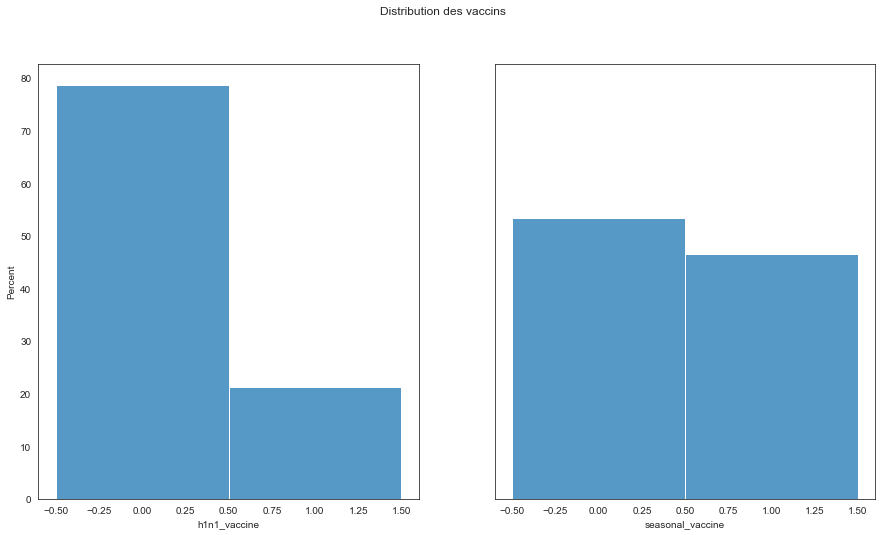

In [15]:
f, axes = plt.subplots(1,2, sharey=True, figsize=(15,8))
f.suptitle("Distribution des vaccins")
sns.histplot(data=data,x="h1n1_vaccine", stat="percent", discrete=True, ax=axes[0])
sns.histplot(data=data,x="seasonal_vaccine", stat="percent", discrete=True, ax=axes[1])

Distributions des features
============

On représente la distribution des features

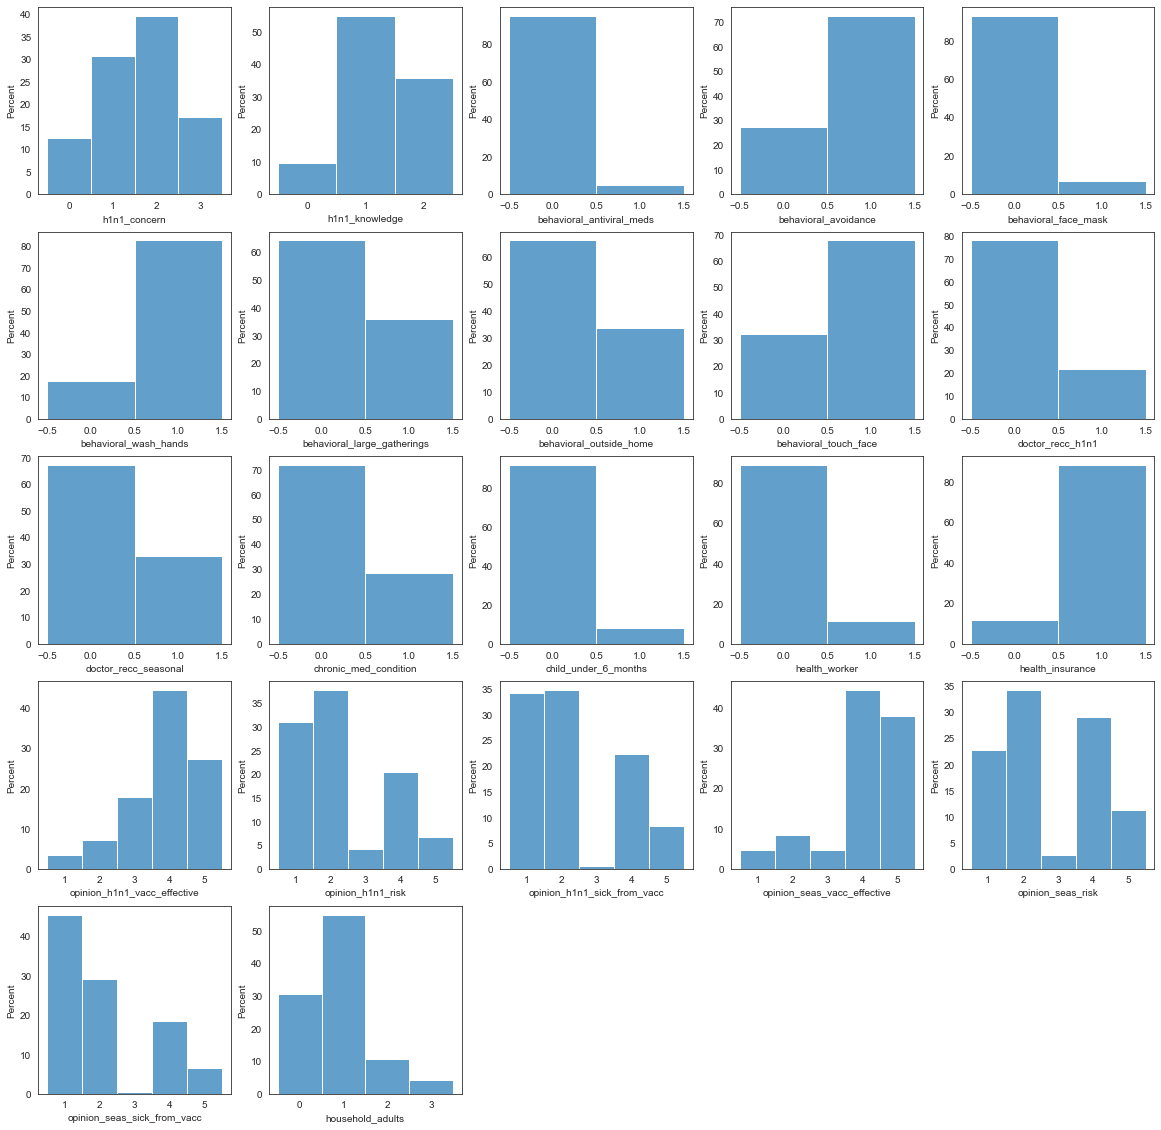

In [16]:
f = plt.figure(figsize=(20,20))
for i in range(1, len(numerical_list)):
    axes = f.add_subplot(5, 5, i)
    sns.histplot(data=data, x=numerical_list[i-1], stat="percent", discrete=True, alpha=0.7)
f.subplots_adjust(wspace=0.2)

On observe que certaines features ne prennent quasiment jamais certaines valeurs

Relations entre labels et features
==========================

On trace les relations entre la vaccination contre la grippe h1n1 et les autres paramètres numériques (ce sont toujours des paramètres discrets)

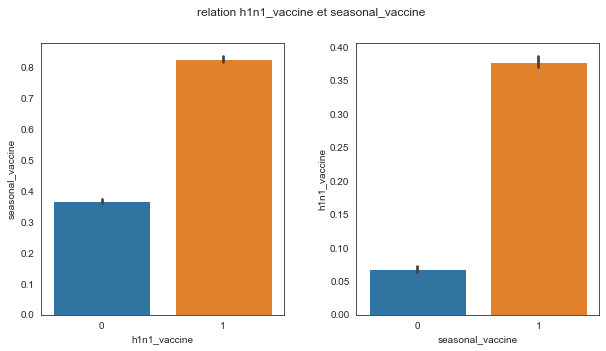

In [17]:
f, axes = plt.subplots(1,2, figsize=(10,5))
f.suptitle("relation h1n1_vaccine et seasonal_vaccine")
sns.barplot(data=data, x="h1n1_vaccine", y="seasonal_vaccine", ax=axes[0])
sns.barplot(data=data, x="seasonal_vaccine", y="h1n1_vaccine", ax=axes[1])
f.subplots_adjust(wspace=0.3)

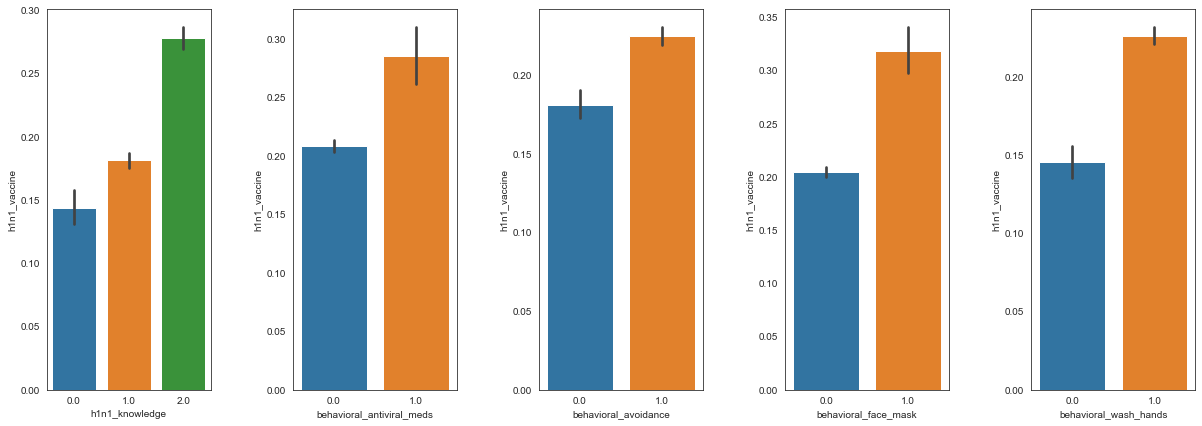

In [24]:
f = plt.figure(figsize=(25,7))
for i in range(1,6):
    axes = f.add_subplot(1,6,i)
    sns.barplot(data=data, x=numerical_list[i], y="h1n1_vaccine")
f.subplots_adjust(wspace=0.5)

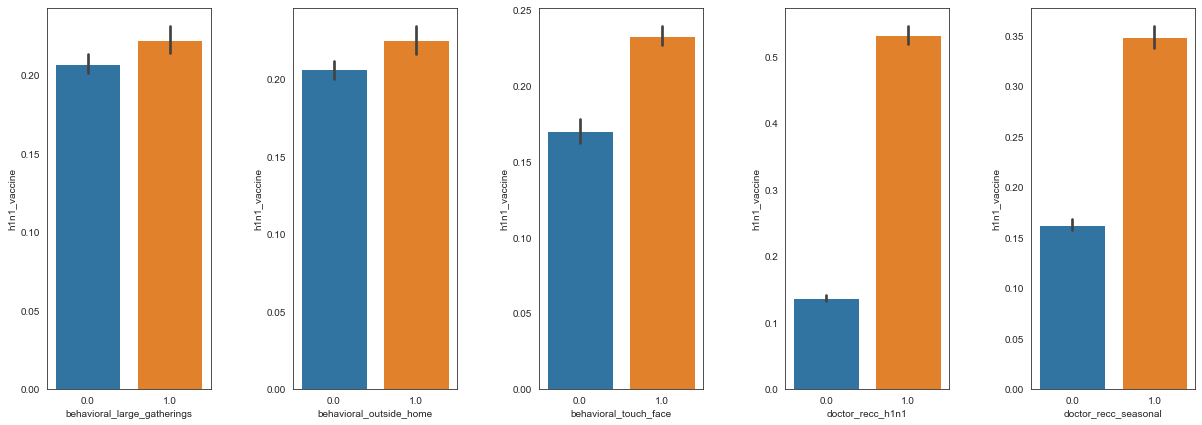

In [25]:
f = plt.figure(figsize=(25,7))
for i in range(1,6):
    axes = f.add_subplot(1,6,i)
    sns.barplot(data=data, x=numerical_list[i+5], y="h1n1_vaccine")
f.subplots_adjust(wspace=0.5)

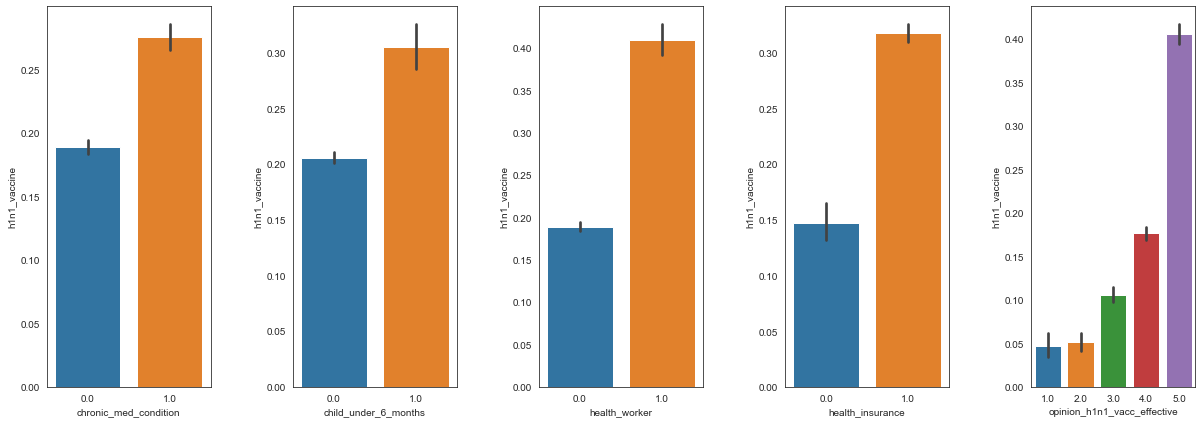

In [28]:
f = plt.figure(figsize=(25,7))
for i in range(1,6):
    axes = f.add_subplot(1,6,i)
    sns.barplot(data=data, x=numerical_list[i+10], y="h1n1_vaccine")
f.subplots_adjust(wspace=0.5)

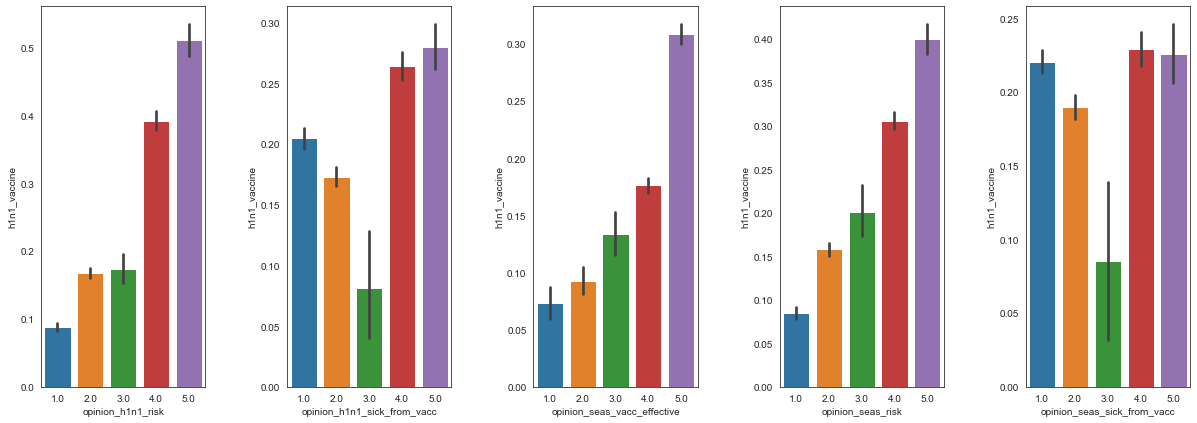

In [29]:
f = plt.figure(figsize=(25,7))
for i in range(1,6):
    axes = f.add_subplot(1,6,i)
    sns.barplot(data=data, x=numerical_list[i+15], y="h1n1_vaccine")
f.subplots_adjust(wspace=0.5)

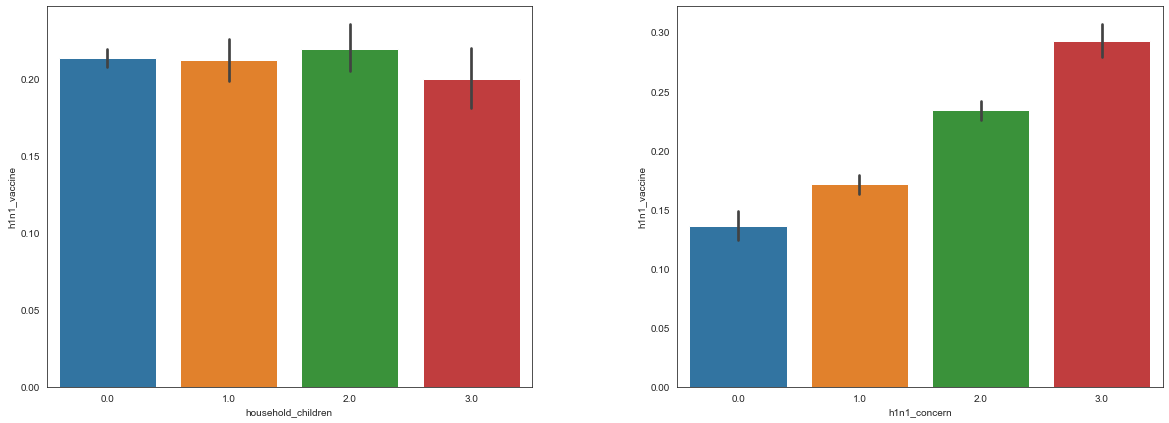

In [22]:
f = plt.figure(figsize=(20,7))
for i in range(1,3):
    axes = f.add_subplot(1,2,i)
    sns.barplot(data=data, x=numerical_list[-2 + i], y="h1n1_vaccine")
f.subplots_adjust(wspace=0.3)

Recherche de corrélation entre les labels et features
-----------------------------------------------------

On utilise une matrice de corrélation qu'on peut représenter de manière plus visuelle

In [ ]:
corr_matrix = data.corr()
corr_matrix['h1n1_vaccine'].sort_values(ascending=False)

In [ ]:
corr_matrix['seasonal_vaccine'].sort_values(ascending=False)

In [ ]:
f = plt.figure(figsize=(20,13))
sns.heatmap(corr_matrix, annot=True, fmt='.1g')

In [ ]:
best_corr_attributes = ['opinion_seas_risk', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_vacc_effective', 'health_insurance', 'doctor_recc_h1n1', 'health_worker']

On trouve de bonnes corrélations (linéaires), top paramètres

On remarque que quelqu'un qui prend un des vaccins a pas mal de chances de prendre le deuxième : comment intégrer ce lien dans les algos classiques ?

Codage des attributs catégoriels textuels
--------------------------

In [ ]:
data_categorical = data.loc[:, categorical_list] # Données catégorielles

ordinal_encoder = OrdinalEncoder()
data_categorical_encoded = ordinal_encoder.fit_transform(data_categorical)
data_categorical_encoded = pd.DataFrame(data_categorical_encoded, columns=categorical_list)

In [ ]:
data_categorical_encoded.info()

knn_imputer_categorical = KNNImputer(n_neighbors=10, weights="uniform")
data_categorical_encoded_array = knn_imputer_categorical.fit_transform(data_categorical_encoded)

In [ ]:
data_categorical_encoded = pd.DataFrame(data_categorical_encoded_array, columns=data_categorical_encoded.columns)

In [ ]:
data_categorical_encoded.isna().describe()

In [ ]:
data_categorical_encoded.shape

Données numériques
--------------------

On va essayer de remplir les valeurs manquantes avec le KNNImputer mais on peut aussi utiliser le simpleImputer et la médiane

In [ ]:
data_numerical = data.loc[:, numerical_list + labels_list]

In [ ]:
knn_imputer_numerical = KNNImputer(n_neighbors=10, weights="uniform")
data_numerical_array = knn_imputer_numerical.fit_transform(data_numerical)
data_numerical = pd.DataFrame(data_numerical_array, columns=data_numerical.columns)

In [ ]:
data_numerical.isna().describe()

In [ ]:
data_numerical.shape

On refusionne les données catégorielles avec les données numériques

In [ ]:
data_encoded = pd.merge(data_numerical, data_categorical_encoded, left_index=True, right_index=True) # inner join sur les indexes
data_encoded.info()

On a comblé tous les trous, à voir si les valeurs comblées sont cohérentes : on peut les marquer avec scikit-learn

# Training Data

Les données ont été comblées par le KNNImputer

In [ ]:
Y = data_encoded.loc[:, ["h1n1_vaccine"]].to_numpy()
X = data_encoded.drop(labels_list, axis=1).to_numpy()

shape_train_data = X.shape[1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size=0.2)

# Machine learning classification

Stratégie
=======

Globalement:
* On veut créer plusieurs modèles, garder les meilleurs, et tous les utiliser par un système de votes pour avoir le modèle final le plus efficace possible

Précisément
* Pour prévoir 'h1n1_vaccine' et 'seasonal_vaccine', on peut d'abord prévoir l'un puis utiliser la corrélation entre les deux pour prévoir l'autre (modèles de classification classiques)
* On peut utiliser un modèle pour déterminer les deux en même temps (deep learning utilisera les liens entre eux directement)



Random Forest model
============

Prévoir premier label : H1n1_vaccine
-----------

Toutes les données et KNNImputer
-----------------------

In [ ]:
Y_train.shape

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X_train, np.ravel(Y_train))

In [ ]:
y_pred = rnd_clf.predict(X_test)
accuracy_score(Y_test, y_pred)

In [ ]:
roc_auc_score(Y_test, y_pred)

SimpleImputer et médiane
-------------------

In [ ]:
only_numerical_data = data.loc[:, numerical_list]
only_numerical_labels = data.loc[:, ["h1n1_vaccine"]]

In [ ]:
simple_imputer = SimpleImputer(strategy="median")
X = simple_imputer.fit_transform(only_numerical_data)
Y = only_numerical_labels.to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size=0.2)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
rnd_clf2 = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf2.fit(X_train, np.ravel(Y_train))

In [ ]:
y_pred = rnd_clf2.predict(X_test)
accuracy_score(Y_test, y_pred)

In [ ]:
roc_auc_score(Y_test, y_pred)

* Meilleur résultat avec les données comblées par KNNImputer (mais vite fait)
* Pas tellement d'avantage à enlever insurance

Prévoir second label : seasonal_vaccine, RF combinées
----------------------

In [ ]:
Y = data_encoded.loc[:, ["seasonal_vaccine"]].to_numpy()
X = data_encoded.drop("seasonal_vaccine", axis=1).to_numpy() # h1n1_vaccine considéré comme une feature

shape_train_data = X.shape[1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size=0.2)

In [ ]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf.fit(X_train, np.ravel(Y_train))

In [ ]:
y_pred = rf.predict(X_test)
accuracy_score(Y_test, y_pred)

In [ ]:
X = data_encoded.drop(labels_list, axis=1).to_numpy()
h1n1_pred = rnd_clf.predict(X)
X = np.c_[X, h1n1_pred]

In [ ]:
Y = data_encoded.loc[:, labels_list].to_numpy()

In [ ]:
seasonal_pred = rf.predict(X)

In [ ]:
Y_pred = np.c_[h1n1_pred, seasonal_pred]

In [ ]:
accuracy_score(Y, Y_pred)

In [ ]:
roc_auc_score(Y, Y_pred) # Mesure utilisée par DrivenData pour évaluer la performance !

Résultat incroyable en ROC AUC score !!

Avec cette méthode de random forest combinées on atteint un score de 70% ce qui est déjà pas mal !

XGBoost Classifier
=======

Utilisation de la librairie xgboost

In [18]:
import xgboost

In [14]:
def xgb_test(data, labels, numerical_list, categorical_list):

    data = data.drop("respondent_id", axis=1)
    labels = labels.loc[:, ['h1n1_vaccine']].to_numpy()

    # Imputing data
    data_numerical_imputed = numerical_impute(data, numerical_list)
    data_categorical_imputed = categorical_imputing(data, categorical_list)

    # Scaling numerical data
    scaler = StandardScaler()
    data_numerical_scaled = scaler.fit_transform(data_numerical_imputed.to_numpy())
    data_numerical_scaled = pd.DataFrame(data_numerical_scaled, columns=numerical_list)

    # Ordinal encoding categorical data : because easier than one hot
    encoder = OrdinalEncoder()
    data_categorical_encoded = encoder.fit_transform(data_categorical_imputed)
    data_categorical_encoded = pd.DataFrame(data_categorical_encoded, columns=categorical_list)

    # Merging data
    data_imputed_scaled = pd.merge(data_numerical_scaled, data_categorical_encoded, left_index=True, right_index=True)

    # Splitting data
    X_train, X_test, y_train, y_test = train_test_split(data_imputed_scaled, np.ravel(labels), test_size=0.2, random_state=1)

    # Autofeat classifier
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # Scoring on test data
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print("ROCAUC score : ", score)
    return model

In [12]:
data_boost = data_original.copy()
labels = data_boost.loc[:, labels_list]
data_boost.drop(labels_list, inplace=True, axis=1)

In [15]:
model = xgb_test(data_boost, labels, numerical_list, categorical_list) # Il faut changer les noms des features qui contiennent des symboles et des espaces à cause de get dummies

c:\users\romai\documents\projets\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:42:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROCAUC score :  0.8612525449645606


Score de 86.1 % sur la prédiction de 'h1n1_vaccine', c'est sensiblement la même chose qu'avec le deep learning : limite vient des données ?

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

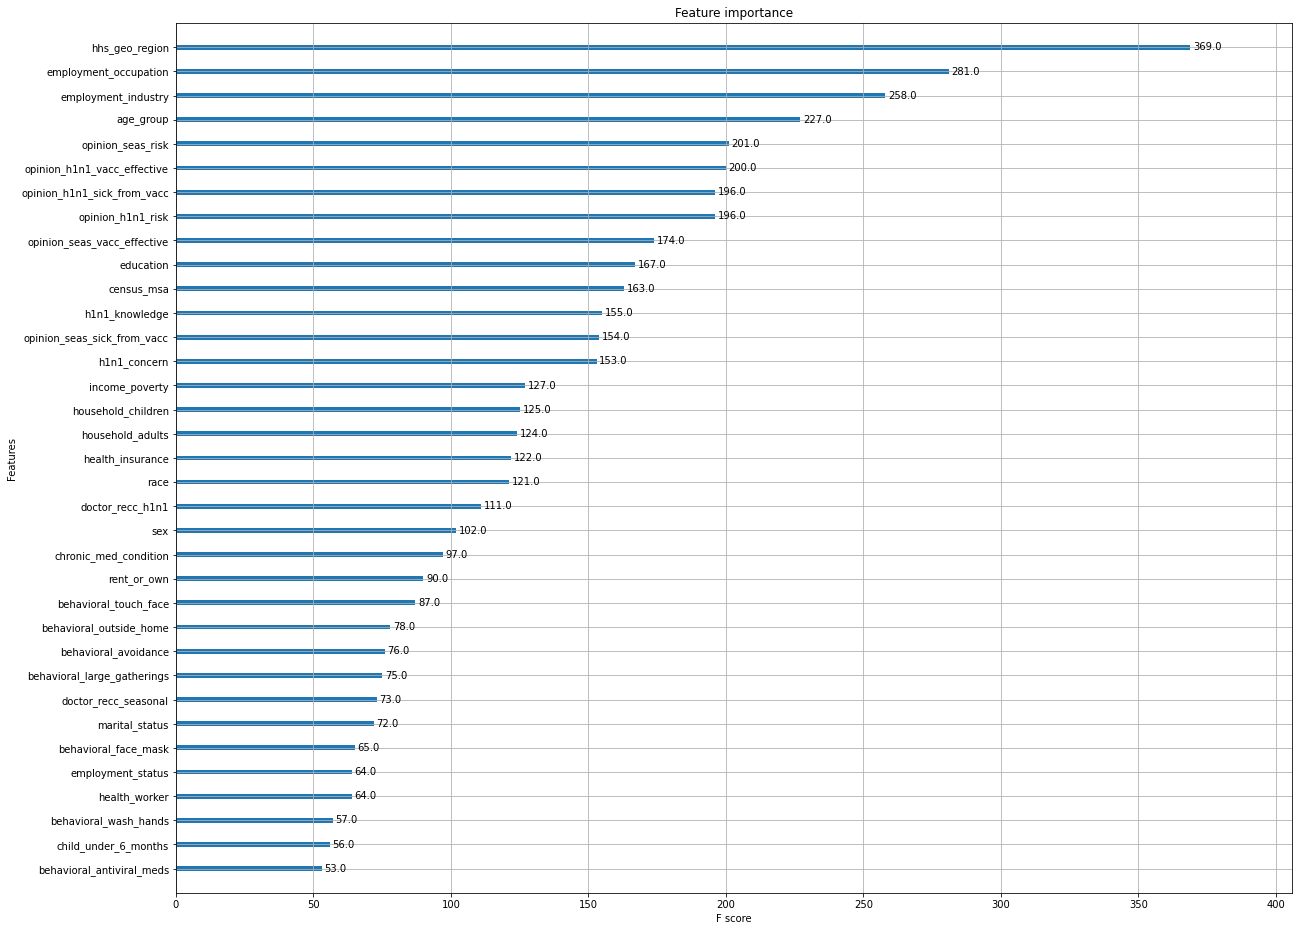

In [23]:
plt.rcParams["figure.figsize"] = (20, 16)
xgboost.plot_importance(model)

# Deep learning classification

Modèle simple
========

* On veut déterminer dles probabilités d'appartenance à une classe : multilabel classification


In [ ]:
Y = data_encoded.loc[:, labels_list].to_numpy()
X = data_encoded.drop(labels_list, axis=1).to_numpy()

shape_train_data = X.shape[1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size=0.2)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, random_state=1, test_size=0.2)

On assemble le modèle, pour l'instant structure simple et séquentielle :

In [ ]:
# modele assez performant : on peut modifier la structure en ajoutant une voie annexe par ex
input_ = keras.layers.Input(shape=shape_train_data)
hidden1 = keras.layers.Dense(35, activation="relu")(input_)
dropout1 = keras.layers.Dropout(0.5)(hidden1)
hidden2 = keras.layers.Dense(15, activation="relu")(dropout1)
output = keras.layers.Dense(2, activation="sigmoid")(hidden2)
model = keras.Model(inputs=[input_], outputs=[output])

model.compile(loss="binary_crossentropy", optimizer="adam")

Le model est assemblé, on sépare les données et on entraine le model :

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

On set up un callback de checkpoint et un early stopping :

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("dl_classification_model_2hidden.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train_scaled, Y_train, epochs=100, validation_data=(X_valid_scaled, Y_valid), callbacks=[checkpoint_cb, early_stopping_cb], verbose=0)

On récupère le meilleur model

In [ ]:
model = keras.models.load_model("dl_classification_model_2hidden.h5")

In [ ]:
mse_test = model.evaluate(X_test_scaled, Y_test)

In [ ]:
Y_pred = model.predict(X_test_scaled)

In [ ]:
Y_pred_binary = Y_pred.round()
accuracy_score(Y_test, Y_pred_binary)

In [ ]:
roc_auc_score(Y_test, Y_pred_binary) # C'est la mesure utilisée par DrivenData

Précision de 73%, c'est pas mal ! On peut toujours voir pour complexifier le réseau mais c'est surement les données qui ne sont pas ouf :
* Sélectionner les meilleurs attributs : selectKbest et chi2
* https://www.datacamp.com/community/tutorials/feature-selection-python
* Réduction de dimension ?
* FillNa par -1 ou 'missing' -> très efficace !
* Feature engineering (featuretools ou autofeat)
* Modèle plus performant : xgb (gradient boosting), en plus il peut montrer l'importance relative des features

Actuellement on a deux modèles renvoyant environ 70% de réussite, en les comparant on peut surement augmenter encore

Test sur toutes les valeurs
-----------------------

Valeurs d'entrainnement

In [ ]:
Y = data_encoded.loc[:, labels_list].to_numpy()
X = data_encoded.drop(labels_list, axis=1).to_numpy()
X_scaled = scaler.transform(X)

In [ ]:
Y_pred = model.predict(X)

In [ ]:
roc_auc_score(Y, Y_pred)

Maintenant il faut tester sur le set de test pour avoir une vrai idée du résultat !
Pour ça il faut faire une fonction pipeline des transformations des données.

Modèles complexes
=============

Réseaux de neuronnes à plusieurs chemins
---------------------

* Pour complexifier le modèle on va ajouter d'autres chemins
* On peut créer un réseau de neuronne extracteur de features